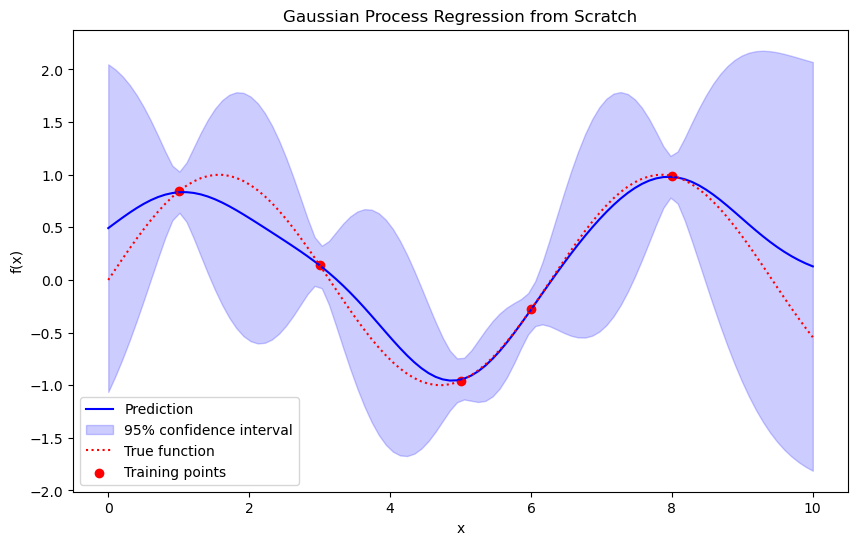

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true function we'll try to learn
def f(x):
    return np.sin(x)

class GaussianProcess:
    def __init__(self, kernel_func, noise_level=1e-2):
        """
        Initialize a Gaussian Process with a specified kernel function
        
        Parameters:
        -----------
        kernel_func : function
            The kernel function to use for computing covariance
        noise_level : float
            The assumed noise level (sigma_n^2) in the observations
        """
        self.kernel_func = kernel_func
        self.noise_level = noise_level
        self.X_train = None
        self.y_train = None
        self.K = None
        
    def fit(self, X_train, y_train):
        """
        Fit the Gaussian Process to training data
        
        Parameters:
        -----------
        X_train : ndarray of shape (n_samples, n_features)
            Training data inputs
        y_train : ndarray of shape (n_samples,)
            Training data outputs
        """
        self.X_train = X_train
        self.y_train = y_train
        
        # Compute the covariance matrix (K) for training points
        self.K = self._compute_covariance(X_train, X_train)
        
        # Add noise to the diagonal
        self.K += self.noise_level * np.eye(len(X_train))
        
        return self
    
    def predict(self, X_test, return_std=False):
        """
        Make predictions at test points
        
        Parameters:
        -----------
        X_test : ndarray of shape (n_samples, n_features)
            Test points to make predictions for
        return_std : bool
            Whether to return standard deviations
            
        Returns:
        --------
        y_pred : ndarray of shape (n_samples,)
            Mean predictions
        std : ndarray of shape (n_samples,), optional
            Standard deviations of predictions
        """
        if self.X_train is None:
            raise ValueError("Model not fitted. Call 'fit' first.")
        
        # Compute the covariance between test and training points
        K_s = self._compute_covariance(X_test, self.X_train)
        
        # Compute the covariance among test points
        K_ss = self._compute_covariance(X_test, X_test)
        
        # Calculate the inverse of K efficiently using Cholesky decomposition
        L = np.linalg.cholesky(self.K)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, self.y_train))
        
        # Calculate mean predictions (posterior mean)
        y_pred = K_s @ alpha
        
        if return_std:
            # Calculate posterior variance
            v = np.linalg.solve(L, K_s.T)
            var = K_ss - v.T @ v
            
            # Ensure positive variance (numerical stability)
            var = np.maximum(var, 1e-6)
            
            # Diagonal elements are the variances of each prediction
            std = np.sqrt(np.diag(var))
            return y_pred, std
        
        return y_pred
    
    def _compute_covariance(self, X1, X2):
        """
        Compute the covariance matrix between X1 and X2 using the kernel function
        
        Parameters:
        -----------
        X1 : ndarray of shape (n_samples_1, n_features)
            First set of input data
        X2 : ndarray of shape (n_samples_2, n_features)
            Second set of input data
            
        Returns:
        --------
        K : ndarray of shape (n_samples_1, n_samples_2)
            Covariance matrix
        """
        n1, n2 = len(X1), len(X2)
        K = np.zeros((n1, n2))
        
        for i in range(n1):
            for j in range(n2):
                K[i, j] = self.kernel_func(X1[i], X2[j])
                
        return K


# Define RBF (Radial Basis Function) kernel
def rbf_kernel(length_scale=1.0, variance=1.0):
    """
    Create an RBF kernel function with specified parameters
    
    Parameters:
    -----------
    length_scale : float
        Length-scale parameter of the kernel
    variance : float
        Variance (amplitude) parameter of the kernel
        
    Returns:
    --------
    kernel_func : function
        The RBF kernel function
    """
    def kernel_func(x1, x2):
        # Convert inputs to arrays for vectorized operations
        x1, x2 = np.asarray(x1), np.asarray(x2)
        # Calculate squared Euclidean distance
        sqr_dist = np.sum((x1 - x2) ** 2)
        # Apply RBF formula
        return variance * np.exp(-0.5 * sqr_dist / (length_scale ** 2))
    
    return kernel_func


# Generate training data
X_train = np.array([1, 3, 5, 6, 8]).reshape(-1, 1)
y_train = f(X_train).ravel()

# Generate test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
y_true = f(X_test).ravel()

# Create and fit Gaussian Process with RBF kernel
kernel = rbf_kernel(length_scale=1.0, variance=1.0)
gp = GaussianProcess(kernel_func=kernel, noise_level=1e-2)
gp.fit(X_train, y_train)

# Make predictions
y_pred, sigma = gp.predict(X_test, return_std=True)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_pred, 'b-', label="Prediction")
plt.fill_between(X_test.ravel(), 
                 y_pred - 1.96 * sigma, 
                 y_pred + 1.96 * sigma, 
                 alpha=0.2, color='blue', label="95% confidence interval")
plt.plot(X_test, y_true, 'r:', label="True function")
plt.scatter(X_train, y_train, color='r', label="Training points")
plt.title("Gaussian Process Regression from Scratch")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

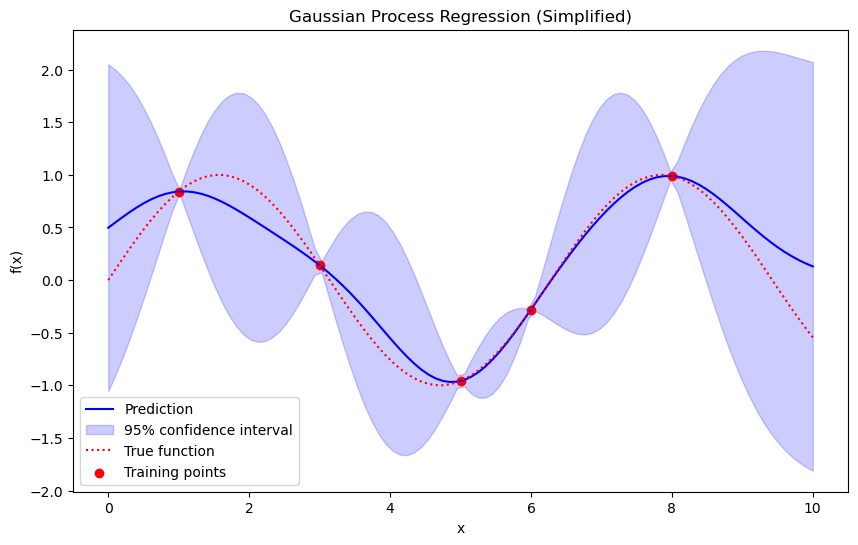

In [7]:
# Define the RBF kernel function
def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    sqdist = np.sum(x1**2, axis=1).reshape(-1, 1) + np.sum(x2**2, axis=1) - 2 * np.dot(x1, x2.T)
    return variance * np.exp(-0.5 / length_scale**2 * sqdist)

# Compute the covariance matrices
K = rbf_kernel(X_train, X_train) + 1e-6 * np.eye(len(X_train))  # Add small noise for numerical stability
K_s = rbf_kernel(X_train, X_test)
K_ss = rbf_kernel(X_test, X_test)

# Compute the mean and covariance of the posterior
K_inv = np.linalg.inv(K)
mu_s = K_s.T @ K_inv @ y_train
cov_s = K_ss - K_s.T @ K_inv @ K_s
sigma_s = np.sqrt(np.diag(cov_s))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(X_test, mu_s, 'b-', label="Prediction")
plt.fill_between(X_test.ravel(), 
                 mu_s - 1.96 * sigma_s, 
                 mu_s + 1.96 * sigma_s, 
                 alpha=0.2, color='blue', label="95% confidence interval")
plt.plot(X_test, f(X_test), 'r:', label="True function")
plt.scatter(X_train, y_train, color='r', label="Training points")
plt.title("Gaussian Process Regression (Simplified)")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.show()

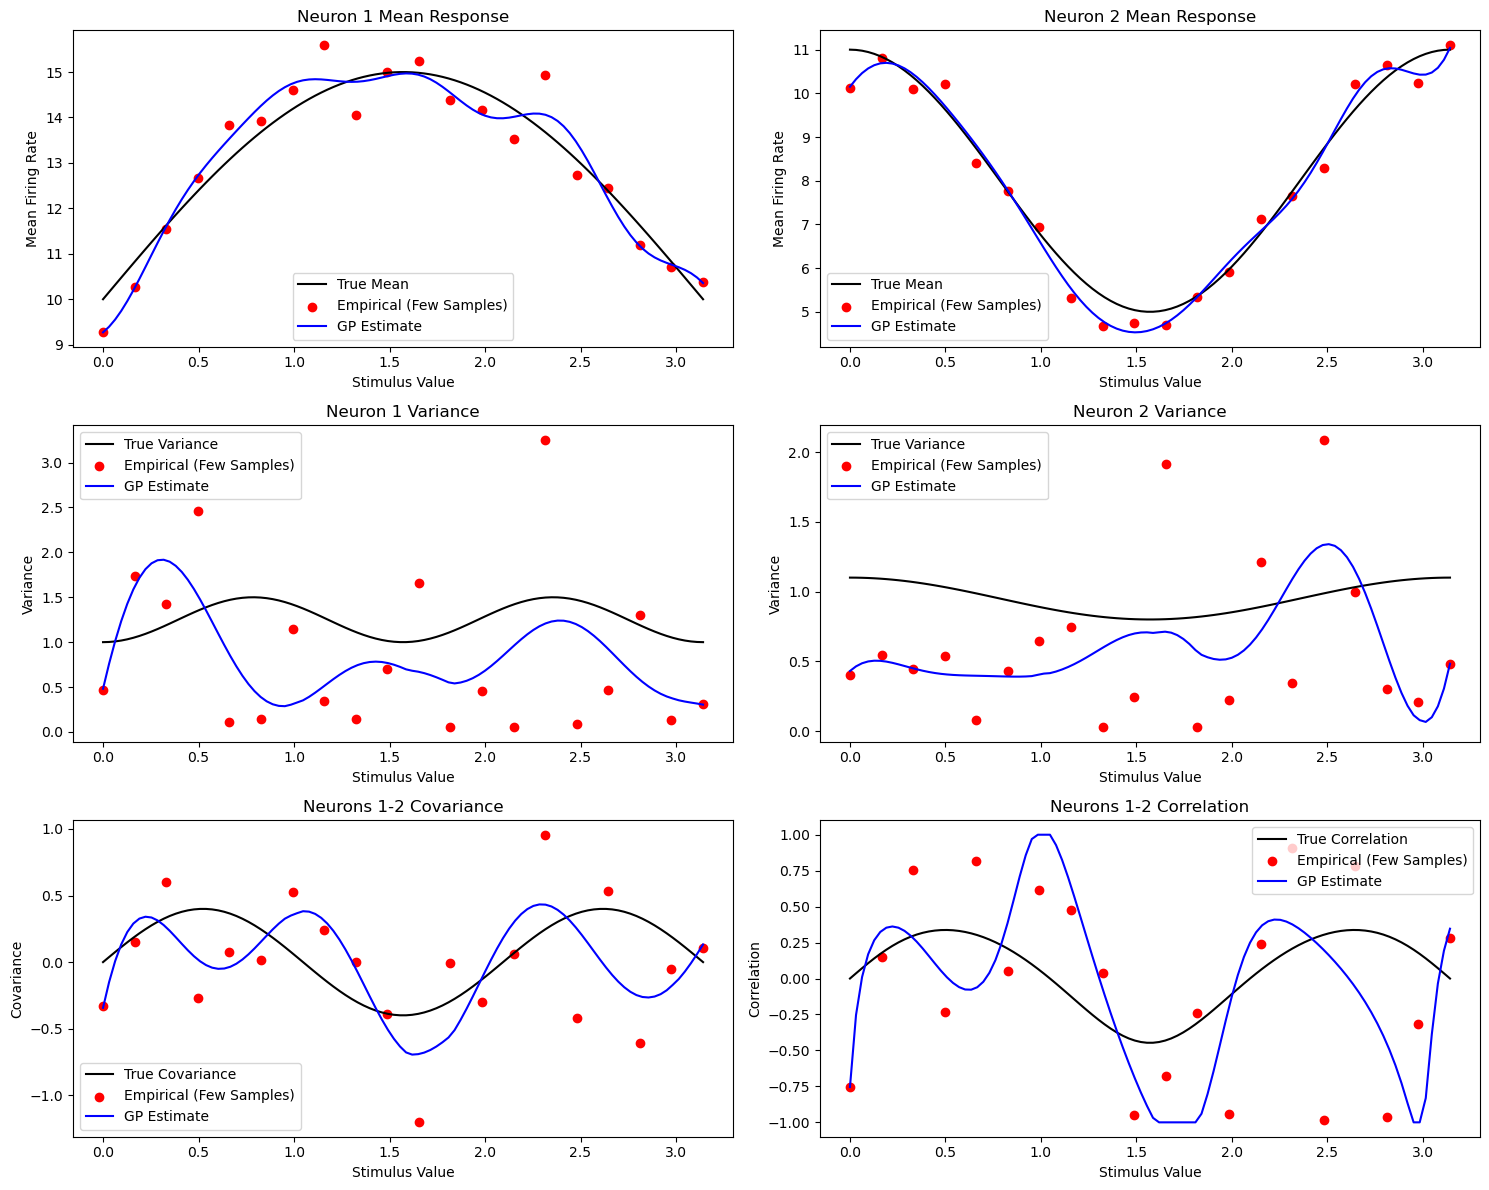

Mean squared error for means:
  Empirical estimate: 0.2465
  GP estimate: 0.1247
  Improvement: 49.4%

Mean squared error for covariances:
  Empirical estimate: 0.4525
  GP estimate: 0.1959
  Improvement: 56.7%


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky

# Set random seed for reproducibility
# np.random.seed(42)

# ===============================
# Step 1: Define our toy problem
# ===============================

# Let's imagine we have 2 neurons (extremely low-dimensional)
n_neurons = 2

# And stimuli that vary along 1 dimension (e.g., orientation from 0 to π)
n_conditions = 20
stimulus_values = np.linspace(0, np.pi, n_conditions)

# We'll define a "ground truth" for how the mean and covariance change with stimulus
# Let's make these functions simple but nonlinear

# True mean functions for our 2 neurons 
def true_mean_neuron1(x):
    return 5 * np.sin(x) + 10

def true_mean_neuron2(x):
    return 3 * np.cos(2*x) + 8

# True covariance evolution - we need 3 functions 
# (variance for neuron 1, variance for neuron 2, and covariance between them)
def true_var_neuron1(x):
    return 1.0 + 0.5 * np.sin(2*x)**2

def true_var_neuron2(x):
    return 0.8 + 0.3 * np.cos(x)**2

def true_covariance(x):
    return 0.4 * np.sin(3*x)

# Generate the true mean and covariance for each stimulus value
true_means = np.zeros((n_conditions, n_neurons))
true_covariances = np.zeros((n_conditions, n_neurons, n_neurons))

for i, x in enumerate(stimulus_values):
    # Compute true means
    true_means[i, 0] = true_mean_neuron1(x)
    true_means[i, 1] = true_mean_neuron2(x)
    
    # Compute true covariance matrix
    cov = np.zeros((n_neurons, n_neurons))
    cov[0, 0] = true_var_neuron1(x)
    cov[1, 1] = true_var_neuron2(x)
    cov[0, 1] = cov[1, 0] = true_covariance(x)
    
    # Ensure the covariance matrix is valid (positive definite)
    # We'll adjust eigenvalues if needed
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    if np.any(eigenvalues < 1e-10):
        eigenvalues = np.maximum(eigenvalues, 1e-10)
        cov = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    true_covariances[i] = cov

# =========================================
# Step 2: Generate synthetic neural data
# =========================================

# We'll generate very few trials per condition to simulate the challenging regime
n_trials_per_condition = 3  # This is much less than n_neurons - the difficult case!

# Generate data
neural_data = np.zeros((n_conditions, n_trials_per_condition, n_neurons))

for i in range(n_conditions):
    for j in range(n_trials_per_condition):
        # Sample from multivariate normal with the true mean and covariance
        neural_data[i, j] = multivariate_normal.rvs(
            mean=true_means[i],
            cov=true_covariances[i]
        )

# =========================================
# Step 3: Standard empirical estimation
# =========================================

# Calculate empirical means and covariances for each condition
empirical_means = np.mean(neural_data, axis=1)
empirical_covs = np.zeros((n_conditions, n_neurons, n_neurons))

for i in range(n_conditions):
    empirical_covs[i] = np.cov(neural_data[i].T, bias=True)  # Use biased estimator for small samples

# =========================================
# Step 4: Implement a simple GP for a single function
# =========================================

def rbf_kernel(x1, x2, length_scale=1.0, variance=1.0):
    """Radial basis function kernel."""
    dist_sq = np.sum((x1 - x2) ** 2)
    return variance * np.exp(-0.5 * dist_sq / (length_scale ** 2))

def compute_kernel_matrix(X, kernel_func, **kernel_params):
    """Compute kernel matrix for a set of points."""
    n = len(X)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = kernel_func(X[i], X[j], **kernel_params)
    return K

def gp_posterior(X_train, y_train, X_test, kernel_func, noise_variance=1e-8, **kernel_params):
    """Calculate the posterior distribution of a GP."""
    # Calculate kernel matrices
    K = compute_kernel_matrix(X_train, kernel_func, **kernel_params)
    K_s = np.array([[kernel_func(x_test, x_train, **kernel_params) 
                    for x_train in X_train] for x_test in X_test])
    K_ss = compute_kernel_matrix(X_test, kernel_func, **kernel_params)
    
    # Add noise to diagonal
    K += noise_variance * np.eye(len(X_train))
    
    # Compute posterior mean and covariance
    K_inv = np.linalg.inv(K)
    posterior_mean = K_s @ K_inv @ y_train
    posterior_cov = K_ss - K_s @ K_inv @ K_s.T
    
    return posterior_mean, posterior_cov

# =========================================
# Step 5: Implement a simplified Wishart process
# =========================================

def simplified_wishart_process(X_train, Y_train, X_test, n_neurons, 
                               length_scale_mean=1.0, length_scale_cov=1.0,
                               noise_variance=1e-4):
    """
    A simplified implementation of the Wishart process idea.
    
    Instead of full Bayesian inference, we'll:
    1. Use GP regression for each mean component
    2. Use GP regression for each unique element of the covariance matrix
    """
    
    X_train = X_train.reshape(-1, 1)  # Ensure correct shape
    X_test = X_test.reshape(-1, 1)
    
    # Extract empirical means and covariances from training data
    emp_means = np.zeros((len(X_train), n_neurons))
    emp_covs = np.zeros((len(X_train), n_neurons, n_neurons))
    
    for i in range(len(X_train)):
        emp_means[i] = np.mean(Y_train[i], axis=0)
        emp_covs[i] = np.cov(Y_train[i].T, bias=True)  # Use biased estimator for small samples
    
    # 1. GP regression for each mean component
    posterior_means = np.zeros((len(X_test), n_neurons))
    for n in range(n_neurons):
        gp_mean, _ = gp_posterior(
            X_train, emp_means[:, n], X_test, 
            rbf_kernel, noise_variance=noise_variance,
            length_scale=length_scale_mean, variance=1.0
        )
        posterior_means[:, n] = gp_mean
    
    # 2. GP regression for each unique element of covariance matrix
    posterior_covs = np.zeros((len(X_test), n_neurons, n_neurons))
    
    # Process each element of the covariance matrix
    for i in range(n_neurons):
        for j in range(i+1):  # Only need lower triangular due to symmetry
            # Extract the (i,j) element from each covariance matrix
            cov_element = emp_covs[:, i, j]
            
            # Apply GP regression
            gp_cov_element, _ = gp_posterior(
                X_train, cov_element, X_test,
                rbf_kernel, noise_variance=noise_variance,
                length_scale=length_scale_cov, variance=1.0
            )
            
            # Store the result
            posterior_covs[:, i, j] = gp_cov_element
            if i != j:  # Fill in the symmetric element
                posterior_covs[:, j, i] = gp_cov_element
    
    # Ensure all covariance matrices are valid (positive definite)
    for i in range(len(X_test)):
        eigenvalues, eigenvectors = np.linalg.eigh(posterior_covs[i])
        if np.any(eigenvalues < 1e-10):
            eigenvalues = np.maximum(eigenvalues, 1e-10)
            posterior_covs[i] = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    return posterior_means, posterior_covs

# =========================================
# Step 6: Apply our model
# =========================================

# Reshape stimulus values for GP input
X_train = stimulus_values.reshape(-1, 1)
X_test = np.linspace(0, np.pi, 100).reshape(-1, 1)

# Apply our simplified Wishart process
wishart_means, wishart_covs = simplified_wishart_process(
    stimulus_values, neural_data, X_test, n_neurons,
    length_scale_mean=0.5, length_scale_cov=0.7,
    noise_variance=1e-4
)

# =========================================
# Step 7: Visualize results
# =========================================

# Compute true values at test points for comparison
true_test_means = np.zeros((len(X_test), n_neurons))
true_test_covs = np.zeros((len(X_test), n_neurons, n_neurons))

for i, x in enumerate(X_test.ravel()):
    # True means
    true_test_means[i, 0] = true_mean_neuron1(x)
    true_test_means[i, 1] = true_mean_neuron2(x)
    
    # True covariance
    cov = np.zeros((n_neurons, n_neurons))
    cov[0, 0] = true_var_neuron1(x)
    cov[1, 1] = true_var_neuron2(x)
    cov[0, 1] = cov[1, 0] = true_covariance(x)
    
    # Ensure validity
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    if np.any(eigenvalues < 1e-10):
        eigenvalues = np.maximum(eigenvalues, 1e-10)
        cov = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    true_test_covs[i] = cov

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Plot means
for n in range(n_neurons):
    ax = axes[0, n]
    ax.plot(X_test, true_test_means[:, n], 'k-', label='True Mean')
    ax.scatter(X_train, empirical_means[:, n], color='r', label='Empirical (Few Samples)')
    ax.plot(X_test, wishart_means[:, n], 'b-', label='GP Estimate')
    ax.set_title(f'Neuron {n+1} Mean Response')
    ax.set_xlabel('Stimulus Value')
    ax.set_ylabel('Mean Firing Rate')
    ax.legend()

# Plot variances
for n in range(n_neurons):
    ax = axes[1, n]
    ax.plot(X_test, true_test_covs[:, n, n], 'k-', label='True Variance')
    ax.scatter(X_train, empirical_covs[:, n, n], color='r', label='Empirical (Few Samples)')
    ax.plot(X_test, wishart_covs[:, n, n], 'b-', label='GP Estimate')
    ax.set_title(f'Neuron {n+1} Variance')
    ax.set_xlabel('Stimulus Value')
    ax.set_ylabel('Variance')
    ax.legend()

# Plot covariance
ax = axes[2, 0]
ax.plot(X_test, true_test_covs[:, 0, 1], 'k-', label='True Covariance')
ax.scatter(X_train, empirical_covs[:, 0, 1], color='r', label='Empirical (Few Samples)')
ax.plot(X_test, wishart_covs[:, 0, 1], 'b-', label='GP Estimate')
ax.set_title('Neurons 1-2 Covariance')
ax.set_xlabel('Stimulus Value')
ax.set_ylabel('Covariance')
ax.legend()

# Plot correlation
ax = axes[2, 1]
# Calculate true correlations
true_corrs = np.zeros(len(X_test))
emp_corrs = np.zeros(len(X_train))
gp_corrs = np.zeros(len(X_test))

for i in range(len(X_test)):
    true_corrs[i] = true_test_covs[i, 0, 1] / np.sqrt(true_test_covs[i, 0, 0] * true_test_covs[i, 1, 1])
    gp_corrs[i] = wishart_covs[i, 0, 1] / np.sqrt(wishart_covs[i, 0, 0] * wishart_covs[i, 1, 1])

for i in range(len(X_train)):
    emp_corrs[i] = empirical_covs[i, 0, 1] / np.sqrt(empirical_covs[i, 0, 0] * empirical_covs[i, 1, 1])

ax.plot(X_test, true_corrs, 'k-', label='True Correlation')
ax.scatter(X_train, emp_corrs, color='r', label='Empirical (Few Samples)')
ax.plot(X_test, gp_corrs, 'b-', label='GP Estimate')
ax.set_title('Neurons 1-2 Correlation')
ax.set_xlabel('Stimulus Value')
ax.set_ylabel('Correlation')
ax.legend()

plt.tight_layout()
plt.show()

# =========================================
# Step 8: Compare prediction errors
# =========================================

# Evaluate at original stimulus values for comparison
eval_means, eval_covs = simplified_wishart_process(
    stimulus_values, neural_data, stimulus_values.reshape(-1, 1), n_neurons,
    length_scale_mean=0.5, length_scale_cov=0.7,
    noise_variance=1e-4
)

# Calculate errors for empirical and GP estimates
mean_error_empirical = np.mean((empirical_means - true_means)**2)
mean_error_gp = np.mean((eval_means - true_means)**2)

cov_error_empirical = np.mean((empirical_covs - true_covariances)**2)
cov_error_gp = np.mean((eval_covs - true_covariances)**2)

print(f"Mean squared error for means:")
print(f"  Empirical estimate: {mean_error_empirical:.4f}")
print(f"  GP estimate: {mean_error_gp:.4f}")
print(f"  Improvement: {(1 - mean_error_gp/mean_error_empirical)*100:.1f}%")

print(f"\nMean squared error for covariances:")
print(f"  Empirical estimate: {cov_error_empirical:.4f}")
print(f"  GP estimate: {cov_error_gp:.4f}")
print(f"  Improvement: {(1 - cov_error_gp/cov_error_empirical)*100:.1f}%")